In [0]:

GOOGLE_COLAB = True
path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')
    path = "/content/drive/My Drive/skin-cancer-malignant-vs-benign/"
training_data_dir = path + "train" # 10 000 * 2
training_data_benign = path + "train/benign/" # 10 000 * 2
training_data_malignant = path + "train/malignant" 
test_data_dir = path + "test" # 12 500
test_data_benign = path + "test/benign"
test_data_malignant = path + "test/malignant"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
train_cancer = os.listdir(training_data_dir)
print(train_cancer[:2])

test_cancer = os.listdir(test_data_dir)
print(test_cancer[:2])

['benign', 'malignant']
['malignant', 'benign']


In [0]:
print('total training cancer images:', len(os.listdir(training_data_dir)))

total training cancer images: 2


In [0]:

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from PIL import Image
np.random.seed(11)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50



Using TensorFlow backend.


In [0]:
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(training_data_benign, filename)) for filename in os.listdir(training_data_benign)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(training_data_malignant, filename)) for filename in os.listdir(training_data_malignant)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(test_data_benign, filename)) for filename in os.listdir(test_data_benign)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(test_data_malignant, filename)) for filename in os.listdir(test_data_malignant)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


In [0]:
y_benign=np.zeros(X_benign.shape[0])
y_malignant=np.ones(X_malignant.shape[0])
y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [0]:
X_train=np.concatenate((X_benign,X_malignant),axis=0)
y_train=np.concatenate((y_benign,y_malignant),axis=0)
X_test=np.concatenate((X_benign_test,X_malignant_test),axis=0)
y_test=np.concatenate((y_benign_test,y_malignant_test),axis=0)


In [0]:
s=np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train=X_train[s]
y_train=y_train[s]
s=np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test=X_test[s]
y_test=y_test[s]

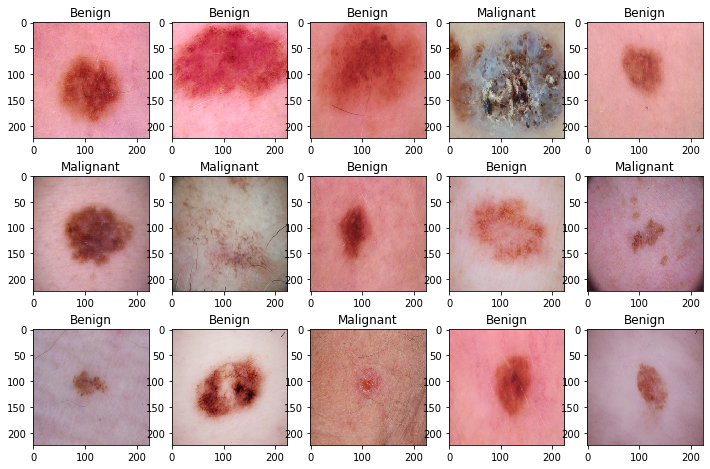

In [0]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12,8))
columns=5
rows=3
for i in range(1,columns*rows +1):
  ax=fig.add_subplot(rows,columns,i)
  if y_train[i]==0:
    ax.title.set_text('Benign')
  else:
    ax.title.set_text('Malignant')
  plt.imshow(X_train[i],interpolation='nearest')
plt.show()

In [0]:
y_train=to_categorical(y_train,num_classes=2)
y_test=to_categorical(y_test,num_classes=2)

In [0]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

In [0]:
def build(input_shape=(224,224,3),lr=1e-3,num_classes=2,init='normal',activ='relu',optim='adam'):
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),padding='Same',input_shape=input_shape,activation=activ,kernel_initializer='glorot_uniform'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64,kernel_size=(3,3),padding='Same',input_shape=input_shape,activation=activ,kernel_initializer='glorot_uniform'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128,activation='relu',kernel_initializer=init))
  model.add(Dense(num_classes,activation='softmax'))
  model.summary()
  if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

  else:
        optimizer = Adam(lr=lr)
  model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=["accuracy"])

  return model

learning_rate_reduction=ReduceLROnPlateau(monitor='val_acc',patience=5,verbose=1,factor=0.5,min_lr=1e-7)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 64)        0         

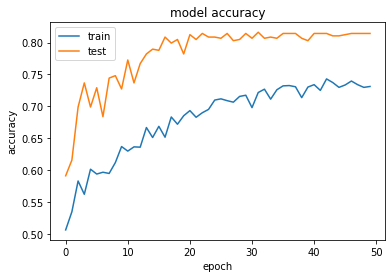

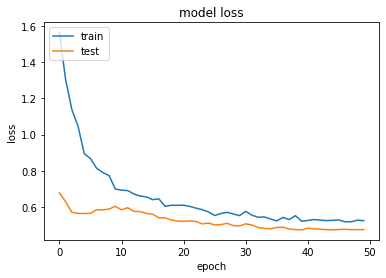

In [0]:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)           



Train on 2109 samples, validate on 528 samples
Epoch 1/50
 - 50s - loss: 0.7634 - acc: 0.6686 - val_loss: 0.8588 - val_acc: 0.5417
Epoch 2/50
 - 30s - loss: 0.5208 - acc: 0.7463 - val_loss: 0.5183 - val_acc: 0.7311
Epoch 3/50
 - 29s - loss: 0.4562 - acc: 0.7634 - val_loss: 0.4627 - val_acc: 0.7595
Epoch 4/50
 - 30s - loss: 0.4271 - acc: 0.7843 - val_loss: 0.4992 - val_acc: 0.7386
Epoch 5/50
 - 30s - loss: 0.4181 - acc: 0.7999 - val_loss: 0.4701 - val_acc: 0.7557
Epoch 6/50
 - 30s - loss: 0.3902 - acc: 0.8004 - val_loss: 0.5030 - val_acc: 0.7348
Epoch 7/50
 - 30s - loss: 0.3766 - acc: 0.8160 - val_loss: 0.3813 - val_acc: 0.8277
Epoch 8/50
 - 30s - loss: 0.3575 - acc: 0.8265 - val_loss: 0.3762 - val_acc: 0.8277
Epoch 9/50
 - 30s - loss: 0.3541 - acc: 0.8298 - val_loss: 0.5161 - val_acc: 0.7424
Epoch 10/50
 - 30s - loss: 0.3529 - acc: 0.8388 - val_loss: 0.3517 - val_acc: 0.8371
Epoch 11/50
 - 29s - loss: 0.3357 - acc: 0.8393 - val_loss: 0.3973 - val_acc: 0.8371
Epoch 12/50
 - 29s - loss

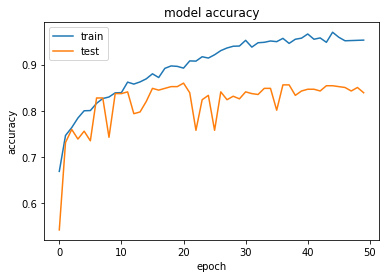

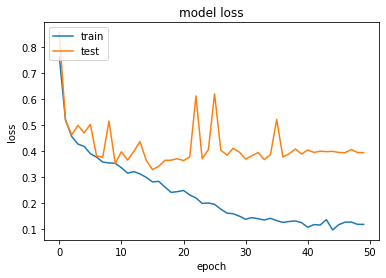

In [0]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1379: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [0]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

0.8303030303030303
Saved model to disk


In [0]:


model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.005),
              metrics=['acc'])
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zca_whitening=True)

test = ImageDataGenerator(rescale = 1./255)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [0]:
img_width, img_height = 256, 256
nb_train_samples = 2667
nb_validation_samples = 660 
batch_size = 16
epochs = 50

In [0]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping



model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))





80142336/80134624 [==============================] - 2s 0us/step








In [0]:
img_width, img_height = 256, 256
nb_train_samples = 2667
nb_validation_samples = 660
batch_size = 16
epochs = 50 

In [0]:


#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(2, activation="sigmoid")(x)
# creating the final model 
model = Model(input = model.input, output = predictions)

# compile the model 
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


In [0]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)


In [0]:
train_generator = train_datagen.flow_from_directory(
training_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [0]:
from keras.callbacks import CSVLogger
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"

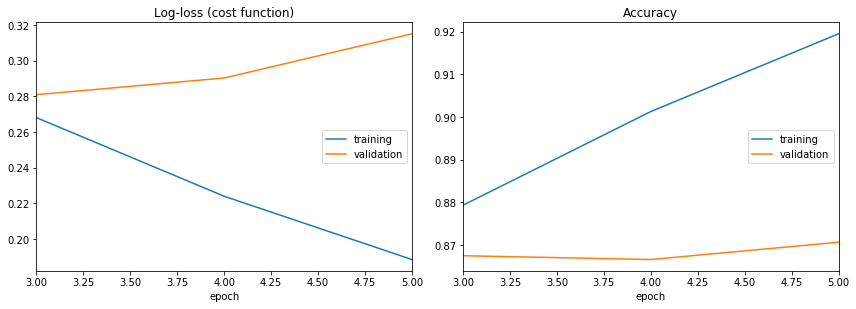

Log-loss (cost function):
training   (min:    0.188, max:    0.397, cur:    0.188)
validation (min:    0.281, max:    0.347, cur:    0.315)

Accuracy:
training   (min:    0.809, max:    0.920, cur:    0.920)
validation (min:    0.840, max:    0.871, cur:    0.871)


In [0]:
from livelossplot.keras import PlotLossesCallback
history=model.fit_generator(train_generator,
                         steps_per_epoch = 2667,
                         epochs = 5,
                         validation_data=validation_generator,
                         validation_steps=660,
                         callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

In [0]:
img_width, img_height = 256, 256
nb_train_samples = 2667
nb_validation_samples = 660
batch_size = 16
epochs = 50 

In [0]:

model = applications.VGG19(weights =None, include_top=False, input_shape = (img_width, img_height, 3))

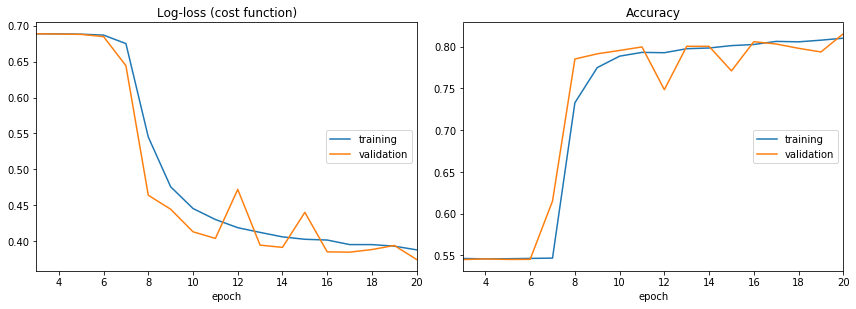

Log-loss (cost function):
training   (min:    0.388, max:    0.691, cur:    0.388)
validation (min:    0.374, max:    0.690, cur:    0.374)

Accuracy:
training   (min:    0.545, max:    0.810, cur:    0.810)
validation (min:    0.545, max:    0.815, cur:    0.815)


In [0]:
from livelossplot.keras import PlotLossesCallback
history=model.fit_generator(train_generator,
                         steps_per_epoch = 2667,
                         epochs = 20,
                         validation_data=validation_generator,
                         validation_steps=660,
                         callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

In [0]:

img_width, img_height = 299, 299
nb_train_samples = 2667
nb_validation_samples = 660 
batch_size = 16
epochs = 50

In [0]:
# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
base_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
# summarize the model
base_model.summary()



87916544/87910968 [==============================] - 2s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________

In [0]:

train_generator = train_datagen.flow_from_directory(
training_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [0]:
from keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout

In [0]:

x = base_model.output
x = AveragePooling2D((8, 8), border_mode='valid', name='avg_pool')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(input=base_model.input, output=predictions)

# compile the model 
model.compile(loss = "binary_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `AveragePooling2D` call to the Keras 2 API: `AveragePooling2D((8, 8), name="avg_pool", padding="valid")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  import sys


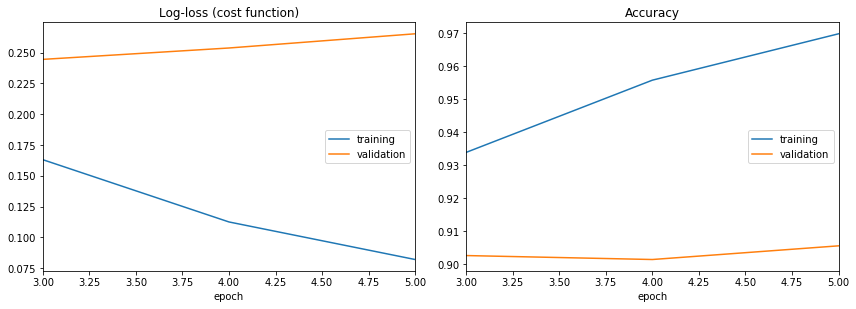

Log-loss (cost function):
training   (min:    0.082, max:    0.365, cur:    0.082)
validation (min:    0.245, max:    0.271, cur:    0.265)

Accuracy:
training   (min:    0.827, max:    0.970, cur:    0.970)
validation (min:    0.875, max:    0.906, cur:    0.906)


In [0]:
from livelossplot.keras import PlotLossesCallback
history=model.fit_generator(train_generator,
                         steps_per_epoch = 2667,
                         epochs = 5,
                         validation_data=validation_generator,
                         validation_steps=660,
                         callbacks=[PlotLossesCallback(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)